In [6]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import datetime
from pandas_datareader import data as pdr
import yfinance as yf

In [7]:
data_source = 'alphavantage' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '<TVUZTK73MRLZABCZ>'

    # Stock prices
    ticker = "SPY"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

   

In [8]:
df.tail()

,Date,Low,High,Close,Open
4,1999-11-05,136.7812,139.1093,137.875,138.625
3,1999-11-04,135.7656,137.3593,136.5312,136.75
2,1999-11-03,135.125,136.375,135.5,136.0
1,1999-11-02,134.5937,137.25,134.5937,135.9687
0,1999-11-01,135.5625,137.0,135.5625,136.5


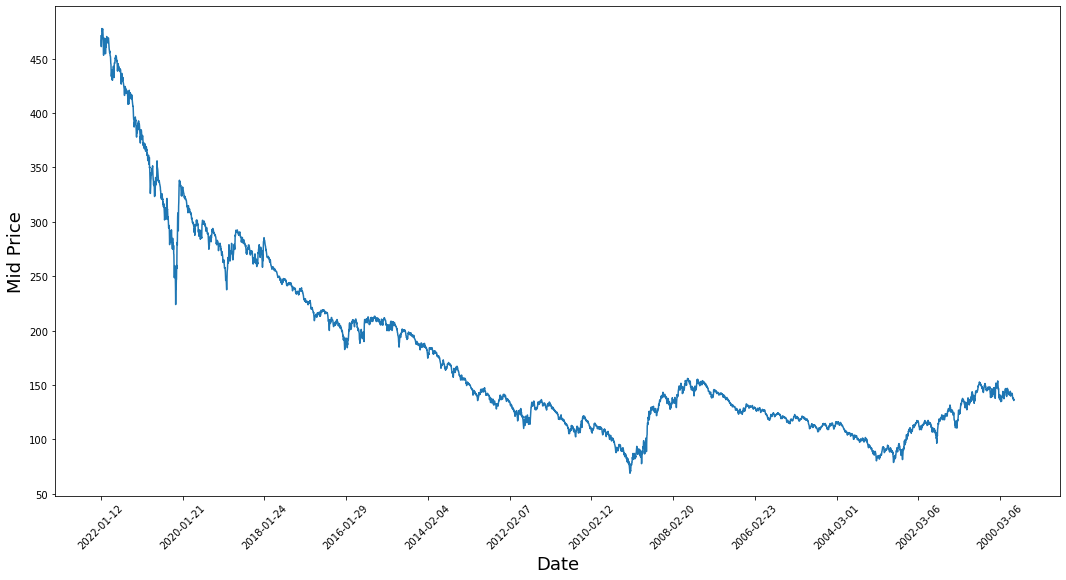

In [9]:
#Data visualization
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

Splitting Data into a Training set and a Test set

In [10]:
# First calculate the mid prices from the highest and lowest

high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0

In [11]:
train_data = mid_prices[:5000]
test_data = mid_prices[5000:]

Normalizing the Data

In [12]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [13]:
# Train the Scaler with training data and smooth data
scaler = MinMaxScaler()
smoothing_window_size = 1100  # Changed 
for di in range(0, len(train_data), smoothing_window_size):   
     scaler.fit(train_data[di:di + smoothing_window_size, :])
     train_data[di:di + smoothing_window_size, :] = scaler.transform(
      train_data[di:di + smoothing_window_size, :])
   

In [14]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

Note that you should only smooth training data.

In [15]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(5000):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

So what do the above graphs (and the MSE) say?

It seems that it is not too bad of a model for very short predictions (one day ahead). Given that stock prices don't change from 0 to 100 overnight, this behavior is sensible. Next, you will look at a fancier averaging technique known as exponential moving average.

Exponential Moving Average formula
In the exponential moving average method, you calculate xt+1 as,

x_t+1=EMA_t=γ×EMAt−1+(1−γ)xt where EMA0=0 and EMA is the exponential moving average value you maintain over time.
The above equation basically calculates the exponential moving average from t+1 time step and uses that as the one step ahead prediction. γ decides what the contribution of the most recent prediction is to the EMA. For example, a γ=0.1 gets only 10% of the current value into the EMA. Because you take only a very small fraction of the most recent, it allows to preserve much older values you saw very early in the average. See how good this looks when used to predict one-step ahead below.


In [16]:
#Calculate the MSE for the EMA
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00008


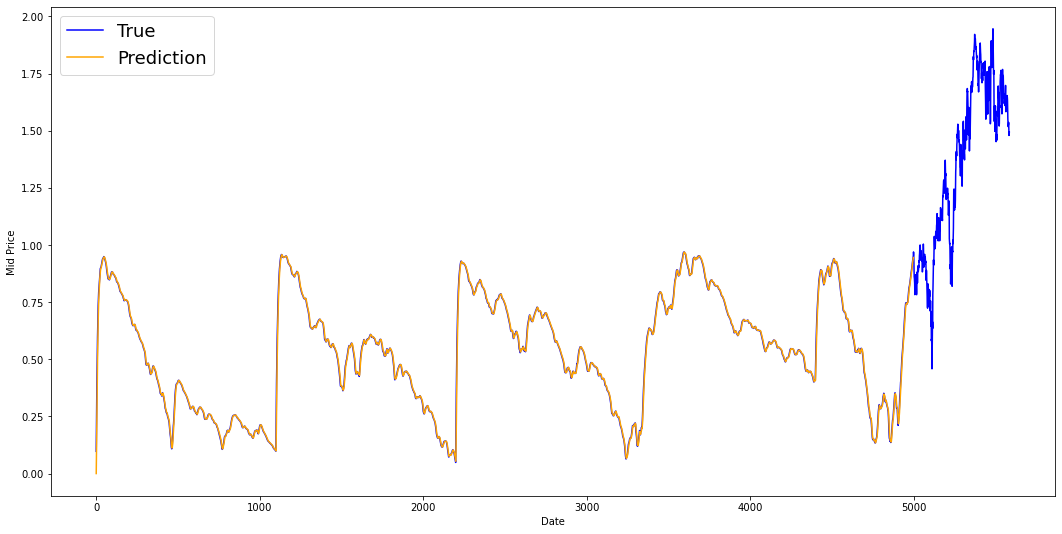

In [17]:
#display the MSE of the EMA
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [18]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

                 Date       Low    High   Close    Open
Date                                                   
2022-01-12 2022-01-12    468.94   473.2  471.02  471.59
2022-01-11 2022-01-11    462.05  469.85  469.75  465.23
2022-01-10 2022-01-10  456.5973  465.74  465.51   462.7
2022-01-07 2022-01-07    464.65   469.2  466.09  467.95
2022-01-06 2022-01-06    465.43  470.82  467.94  467.89
2022-01-05 2022-01-05  468.2801  477.98  468.38  477.16


C:\Users\oziro\anaconda3.2\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  import sys


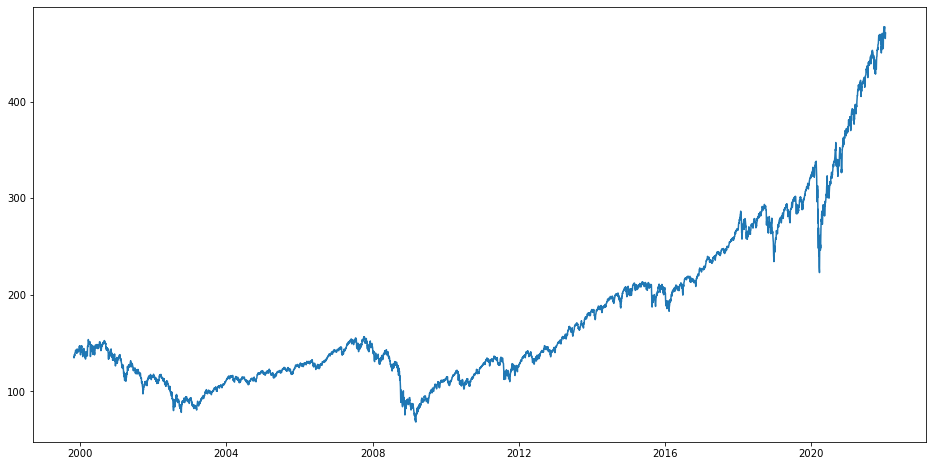

In [19]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
print(df.head(6))
#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], Label='Close Price history')

In [20]:
data = df.sort_index(ascending=True, axis=0)

new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [21]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [22]:
#creating train and test sets
dataset = new_data.values
train = dataset[0:1000,:]
valid = dataset[1000:,:]

In [23]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
print(x_train.shape)

(940, 60, 1)


Define the LSTM Recurrent Neural Network. Here, you can add more LSTM layers and adjust the dropout in order to improve the accuracy of the model.

In [24]:
# create and fit the LSTM network
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

print(regressor.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

Compile and train the model defined in the above step. Iteratively, you can increase or decrease the epochs and batch size to get more accuracy.

In [25]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
regressor.fit(x_train, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
30/30 [==============================] - 61s 286ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 2/15
30/30 [==============================] - 9s 302ms/step - loss: 4.1564e-04 - accuracy: 0.0000e+00
Epoch 3/15
30/30 [==============================] - 9s 303ms/step - loss: 2.9757e-04 - accuracy: 0.0000e+00
Epoch 4/15
30/30 [==============================] - 10s 322ms/step - loss: 2.6436e-04 - accuracy: 0.0000e+00
Epoch 5/15
30/30 [==============================] - 9s 315ms/step - loss: 2.5629e-04 - accuracy: 0.0000e+00
Epoch 6/15
30/30 [==============================] - 9s 304ms/step - loss: 2.2057e-04 - accuracy: 0.0000e+00
Epoch 7/15
30/30 [==============================] - 9s 310ms/step - loss: 2.3546e-04 - accuracy: 0.0000e+00
Epoch 8/15
30/30 [==============================] - 10s 319ms/step - loss: 2.5756e-04 - accuracy: 0.0000e+00
Epoch 9/15
30/30 [==============================] - 9s 306ms/step - loss: 2.2971e-04 - accuracy: 0.0000e+00
Epoch 10/15
30/30 [==========

Now, our model is trained and needs to be tested on the testing data. For this purpose, fetch the new data for a different period. Preprocessing steps are similar as we have done with training data.

In [26]:
import datetime
from pandas_datareader import data as pdr
import yfinance as yf
# Importing necessary paackages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import string

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

seed = 1000

In [27]:
ticker = yf.Ticker("MSFT")

testdataframe= ticker.history(start="2017-01-01", end="2022-01-11")
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata['Date'] = testdataframe['Date']
testdata['Open'] = testdataframe['Open']
testdata['High'] = testdataframe['High']
testdata['Low'] = testdataframe['Low']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((df['Open'], testdata['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(60, 1300):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Test the LSTM model on the new dataset

In [28]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

Visualize the predicted stock prices with original stock prices

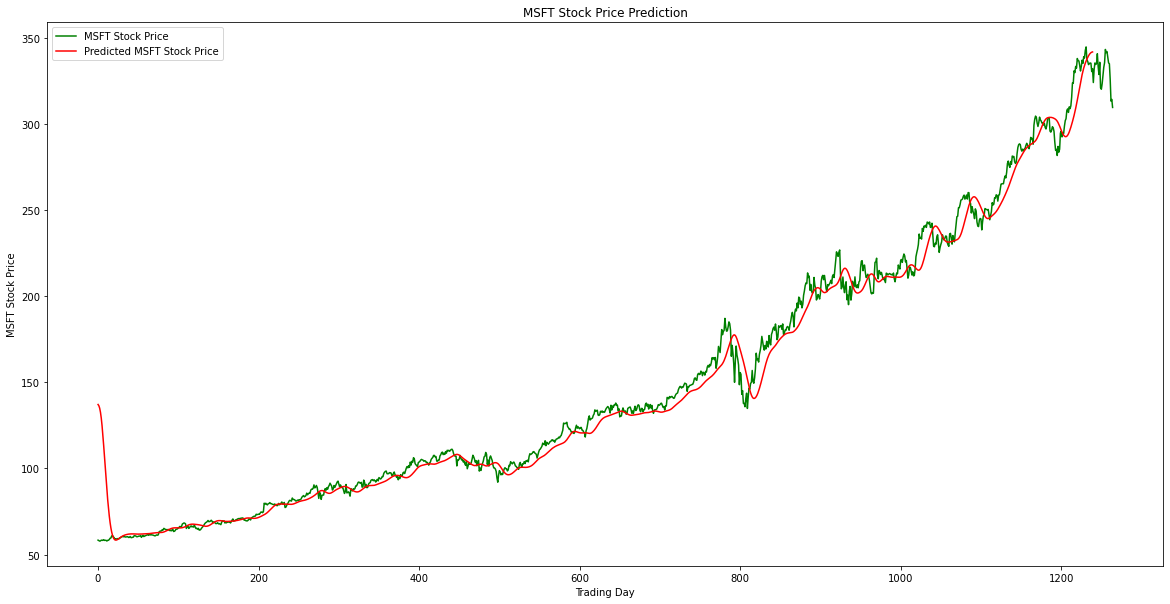

In [29]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'MSFT Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted MSFT Stock Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('MSFT Stock Price')
plt.legend()
plt.show()

TESTING THE MODEL

In [30]:
x_train, X_test, y_train, y_test= train_test_split(x_train, y_train, test_size=0.25, random_state=seed)

In [31]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

embedding_size = 32


In [32]:
#save the model
regressor.save('saved_models.h5')

In [33]:
#create dummies or random variables
y_test_dummies = pd.get_dummies(y_test).values
print('Shape of Label tensor:', y_test_dummies.shape)

Shape of Label tensor: (235, 231)


In [34]:
#model evaluation
from keras.models import load_model

regressor = load_model('saved_models.h5')
score = regressor.evaluate(X_test, y_test_dummies)

LSTM_accuracy = score[1]*100

print('Test accuracy:', score[1]*100, '%')

8/8 [==============================] - 16s 69ms/step - loss: 0.0175 - accuracy: 0.9957
Test accuracy: 99.56709146499634 %
